In this project, data scientist job openings will be web scraped and compared in terms of salaries.

# Motivation
1. Can a data scientist's salary be predicted and if so how accurately?
2. What features are important in predicting a data scientist's salary?
3. Another motivation was to see the relative number of data scientist jobs posted in different states in USA.
4. What industries/sectors pay higher salaries?

# Project overview
- The objective is to predict the salary of data scientist positions based on location, seniority, type of the company, industry, etc.
- The dataset used in this project is a combination of dataset obtained from https://www.kaggle.com/andrewmvd/data-scientist-jobs and extra data scientist positions scraped by glassdoor scraper developed and uploaded to this repository
- Cleaned dataset of over 5500 data scientist positions
- Created and optimized Random Forest Regression model by using GridSearchCV to reach MAE=22.32, RMSE=28.61, and R2score=0.40
- Model was saved using joblib library

# Import Libraries
First, the necessary libraries are imported.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
plt.style.use('seaborn')

# for interactive view of plots
# %matplotlib notebook 

# for static view of plots
%matplotlib inline 

import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Gather Data
The data was scraped and saved in a csv file which we will read in here.

In [2]:
df_raw = pd.read_csv('./data/df.csv')

# Assess Data
In this section, we will check the raw data and get an understanding of what kind of data we are dealing with.

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5892 entries, 0 to 5891
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          5892 non-null   object 
 1   Salary Estimate    5892 non-null   object 
 2   Rating             5892 non-null   float64
 3   Company Name       5892 non-null   object 
 4   Location           5892 non-null   object 
 5   Size               5892 non-null   object 
 6   Founded            5892 non-null   object 
 7   Type of ownership  5892 non-null   object 
 8   Industry           5892 non-null   object 
 9   Sector             5892 non-null   object 
 10  Revenue            5892 non-null   object 
dtypes: float64(1), object(10)
memory usage: 506.5+ KB


As seen above, all the columns except for Rating are in string (object) format. Rating is a float type.

In [4]:
# check how many null values exist in each column
df_raw.isnull().sum()

Job Title            0
Salary Estimate      0
Rating               0
Company Name         0
Location             0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
dtype: int64

# Clean Data
In this section, the data is cleaned and prepared for next steps.

- Parsed the salary estimates out of the raw data
- Created "Hourly" and "Employer_provided" columns to distinguish if a salary estimate was based on hourly rates and provided by the employer, respectively
- Created minimum and maximum salary columns for the positions and parsed the corresponding values out of the raw dat
- Created average salary column
- Cleaned the company name column by removing the ratings
- Extracted the state where each position is located. Created a state column
- Created founded column which contains the year each company was founded
- Using the founded column, the company age column was created
- Seniority column was created to show if a position was a senior role
- Title column was created to show the different categories for the posted roles such as data engineer, deep learning, analyst, ...
- For all the column if the corresponding value was not available, -1 was assigned for the particular position

In [ ]:
def get_clean_dataframe(num_jobs=100):
    """
    Gets raw dataframe directly from glassdoor_scraper.py or from a csv file.
    Cleans the raw dataframe.
    
    args:
        int num_jobs: number of desirable jobs passed to the scraper
    
    return:
        Dataframe df: cleaned dataframe
    """
    
    # df = gs.get_jobs(num_jobs=num_jobs)
    
    df = pd.read_csv('./data/df.csv')
    
    #%% Salary
    
    # Remove instances without salary estimates
    df = df[df['Salary Estimate'] != '-1']
    
    ## Remove K and $ 
    df['Salary Estimate'] = df['Salary Estimate'].apply(lambda x: x.replace('K', '').replace('$', ''))
    
    ## Add hourly and employer provided binary columns
    df['Hourly'] = df['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
    df['Employer_provided'] = df['Salary Estimate'].apply(lambda x: 1 if 'employer est' in x.lower() else 0)
    
    ## Add min, max, and average salary columns and cast them into integer type
    df['Min_salary'] = df['Salary Estimate'].apply(lambda x: int(x.split('-')[0]))
    # df['Max_salary'] = df['Salary Estimate'].apply(lambda x: int(x.split('$')[1]))
    df['Max_salary'] = df['Salary Estimate'].apply(lambda x: x.split('-')[1]).replace('[^0-9]', '', regex=True)
    df['Max_salary'] = df['Max_salary'].apply(int)
    
    ### Convert hourly wages to annual
    df['Min_salary'] = df.apply(lambda x: x.Min_salary if x.Hourly == 0 else x.Min_salary*2.05, axis=1)
    df['Max_salary'] = df.apply(lambda x: x.Max_salary if x.Hourly == 0 else x.Max_salary*2.05, axis=1)
    
    df['Average_salary'] = (df.Min_salary + df.Max_salary)/2
    
    ## Remove the initial salary estimate column
    df.drop('Salary Estimate', axis=1, inplace=True)
    
    #%% Rating
    
    ## Ensure ratings are float type
    df['Rating'] = df['Rating'].apply(lambda x: float(x))
    
    #%% Company name
    
    ## Remove rating from the end of company names
    df['Company Name'] = df['Company Name'].apply(lambda x: x.split('\n')[0])
    
    #%% State: what state is the job in
    
    df['State'] = df['Location'].apply(lambda x: x.split()[-1])
    df = df[df.State != 'Kingdom'] # remove United Kingdom
    df = df[df.State != 'States'] # remove United States
    #%% Company age
    
    # Replace non-numeric cells in Founded column with -1
    df['Founded'].replace('[^0-9]', -1, regex=True, inplace=True)
    
    df['Company_age'] = df['Founded'].apply(lambda x: 2021-int(x) if int(x)>0 else -1)
    
    
    #%% Organize job titles
    
    def title_organizer(x):
        x = x.lower()
        if ('data scientist' in x) or ('data science' in x) :
            return 'data scientist'
        elif 'data engineer' in x:
            return 'data engineer'
        elif 'deep learning' in x:
            return 'deep learning engineer'
        elif 'machine learning' in x:
            return 'machine learning engineer'
        elif 'director' in x:
            return 'director'
        elif 'manager' in x:
            return 'manager'
        elif 'analyst' in x:
            return 'analyst'
        elif 'researcher' in x:
            return 'researcher'
        else:
            return 'other'
    df['Title'] = df['Job Title'].apply(title_organizer)
    
    #%% Senior position?
    
    def senior_junior(x):
        x = x.lower()
        if 'sr' in x or 'senior' in x or 'sr.' in x or 'lead' in x or 'principal' in x or 'vp' in x or 'manager' in x:
            return 'senior'
        elif 'jr' in x or 'junior' in x or 'jr.' in x:
            return 'junior'
        else:
            return 'other'
    df['Seniority'] = df['Job Title'].apply(senior_junior)        
    
    #%% Size
    
    df['Size'].replace('Unknown', '-1', regex=True, inplace=True)
    df['Size'] = df['Size'].str.lower()
    
    #%% Type of ownership
    
    df['Type of ownership'].replace('Unknown', '-1', regex=True, inplace=True)
    
    #%% Drop unwanted columns, reorder the remining columns, and write the dataframe to csv format
    
    # Max_salary and Min_salary are dropped too because we calculated the
    # response variable, Average_salary, by using them.
    df.drop(['Company Name', 'Location', 'Founded', 'Job Title', 
             'Revenue', 'Min_salary', 'Max_salary'], inplace=True,
            axis=1)
    
    df = df.reindex(columns=['Average_salary', 'Title','Seniority', 
                             'Rating', 'Hourly', 'Employer_provided', 
                             'Company_age', 
                             'Industry', 'Sector', 'Type of ownership',
                             'Size', 'State'])
    
    df.to_csv('./data/df_cleaned.csv', index=False)
    
    return df

# run the function
# get_clean_dataframe()

In [5]:
df = pd.read_csv('./data/df_cleaned.csv')

# Check how many null values
df.isnull().sum()

Average_salary       0
Title                0
Seniority            0
Rating               0
Hourly               0
Employer_provided    0
Company_age          0
Industry             0
Sector               0
Type of ownership    0
Size                 0
State                0
dtype: int64

# Exploratory Data Analysis (EDA)
Here, we will take a peek at the data and visualize them.

### Statistical metrics
The statistical metrics, mean, median, etc. are shown for the numerical variables below.

In [6]:
df.describe()

Average_salary       Rating       Hourly  Employer_provided  \
count     5522.000000  5522.000000  5522.000000        5522.000000   
mean       105.474638     3.284951     0.004708           0.011409   
std         35.589310     1.603858     0.068463           0.106211   
min         30.750000    -1.000000     0.000000           0.000000   
25%         76.500000     3.300000     0.000000           0.000000   
50%        101.500000     3.800000     0.000000           0.000000   
75%        129.500000     4.100000     0.000000           0.000000   
max        268.000000     5.000000     1.000000           1.000000   

       Company_age  
count  5522.000000  
mean     39.924846  
std      52.063773  
min      -1.000000  
25%       5.000000  
50%      21.000000  
75%      52.000000  
max     396.000000

## Define functions for creating plots
Next, different plots are created for different features to get a better understanding of data.

In [7]:
def get_hist(df):
    
    """plot histograms for the numerical features
    arg:
        Dataframe df: dataframe of jobs
    """
    df.hist(bins=15)
    plt.show()

In [8]:
def get_boxplot(df, columns_list):
    
    """plot boxplots for the listed numerical features
    args:
        Dataframe df: dataframe of jobs
        list column_list: list of columns you want to be plotted
    """
    df.boxplot(column=columns_list)
    plt.show()

In [9]:
def get_correlation(df):
        
    """plot correlation heatmap for the numerical features
    arg:
        Dataframe df: dataframe of jobs
    """
    ax = plt.axes()
    sns.heatmap(df.corr(), annot=True, fmt='0.2f', ax=ax)
    ax.set_title('Correlation Heatmap')
    plt.show()
    

In [10]:
def get_countplot(df):
    
    """plot bar charts (count plots) for the categorical features
    arg:
        Dataframe df: dataframe of jobs
    """
    for col in df.select_dtypes(include=['object']).columns:
        try: # for columns with more than 20 unique values, only plot top 20
            ax = sns.countplot(x=col, data=df, palette='Spectral',
                               order=df[col].value_counts().iloc[:20].index)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            plt.show()
        except:
            ax = sns.countplot(x=col, data=df, palette='Spectral',
                               order=df[col].value_counts().index)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            plt.show()

## Visualize data

In the following plot, the distributions of numerical features and the response variable (Average_salary) are displayed. It can be seen that the average salary distribution is nearly a normal distribution but skewed to the left. Also, the salary numbers are divided by 1000 and are in USD.

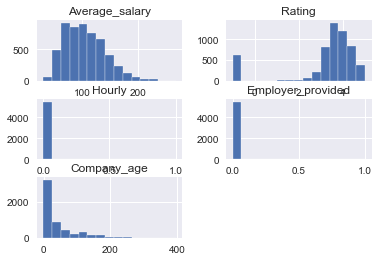

In [11]:
get_hist(df)

Below, the average salaries are shown via a box plot. The median, that is the red line inside the box, is around 100 and also the outliers are displayed with circles.

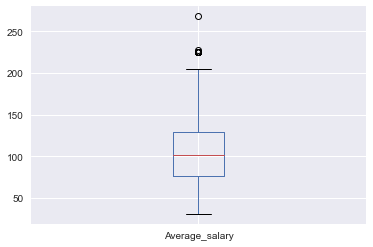

In [12]:
get_boxplot(df, ['Average_salary'])

The following correlation matrix shows that average salary has the highest relationship with Employer_provided among the shown features.

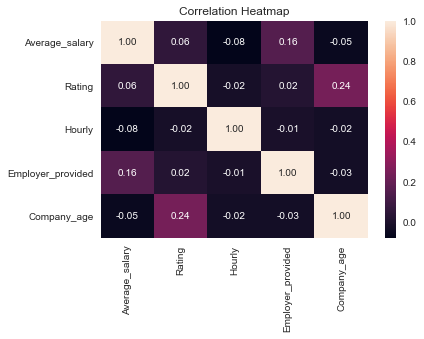

In [13]:
get_correlation(df)

The following plots show the counts for the categorical features. 

- In the Title plot, it can be seen that the largest number of the positions in this data set belongs to data scientists, analyst, and other (any title other than the rest) positions
- In the Seniority plot, it is shown that most positions are unknown in terms of seniority level. Also, there are far more senior positions than junior ones
- According to the Industry plot, the industry of a lot of positions is unknown (-1). Then, IT Services and Pharma have posted a big chunk of positions
- Next, is the Sector plot which shows Information Technology is the dominant sector
- The Type of ownership plot shows that the majority of companies posting job openings are either private or public
- The Size plot shows that typically larger companies have posted more openings
- In the State plot, it is apparent that most of the openings are located in California and Texas, which makes sense considering the high number of large tech companies and businesses in those two states

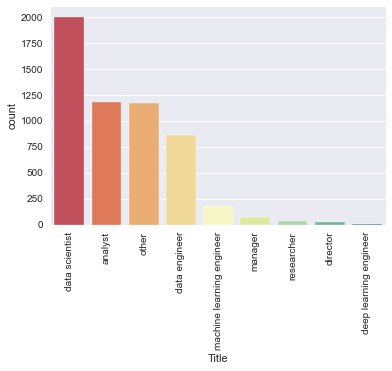

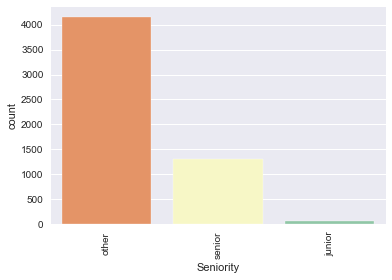

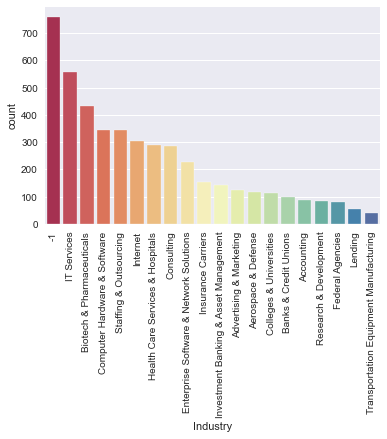

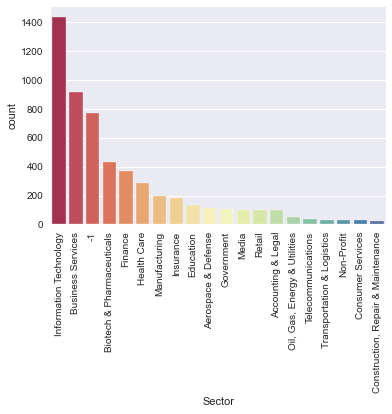

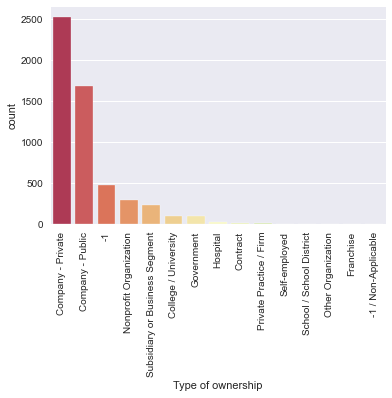

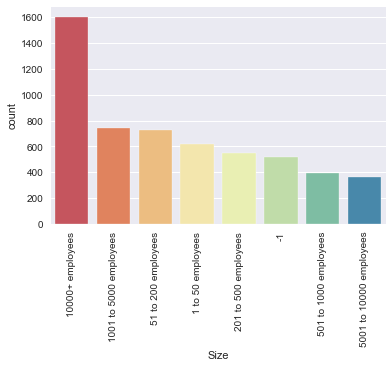

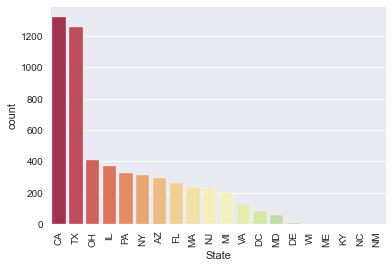

In [14]:
get_countplot(df)

# Model
There several steps to be taken in order to fit a model on the data. We will go through them one by one.

### Extract and save response variable

In [15]:
# extracting the response variable
y = df.pop("Average_salary")

### Extract and save features 
All the independent variables (features) are save into matrix X here. There are no null values in the numerical features, hence no need for filling in the null values there.
On the other hand, using the get_dummies() method in pandas, the categorical features will be one-hot encoded. 

In [16]:
def get_features(X):
    """
    Fills in the null values for numerical values.
    Creates dummies for categorical variables.
    Produces the final feature matrix, X.
    
    arg:
        Dataframe X: dataframe of raw features
    returns:
        Dataframe X: dataframe of preprocessed features
    """
    
    # separating numerical and categorical features into two dataframes
    num_X = X.select_dtypes(include=['int', 'float', 'int64', 'float64'])
    cat_X = X.select_dtypes(include=['object'])

    # creating dummies for categorical variables and producing final X matrix
    for col in cat_X.columns:
        X = pd.concat([X.drop(col, axis=1),
                       pd.get_dummies(X[col], prefix=col, prefix_sep='_',
                                      drop_first=True)], axis=1)
    return X

# saving features matrix as X
X = get_features(df)

### Split X and y into training and test sets and instantiate a random forest regressor

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
                                                            
rf = RandomForestRegressor(criterion='mse')

cv = cross_val_score(rf,X_train,y_train, 
                     scoring='neg_root_mean_squared_error', cv=10)
print("cross validation scores:\n", cv)
print("the average of the cross validation scores: ", cv.mean())


param_grid =  {'n_estimators': [10, 25, 50, 100, 200, 400, 800, 1000],
                                  'bootstrap': [True],
                                  'max_depth': [2, 5, 10, 15, 20],
                                  'max_features': ['auto','sqrt',10],
                                  'min_samples_leaf': [2,3,4,5,6],
                                  'min_samples_split': [2,3,4]}

cross validation scores:
 [-30.10308626 -30.67263747 -28.95698903 -29.13340556 -31.38212311
 -27.76297014 -30.31428031 -28.03242572 -30.25089444 -31.95204216]
the average of the cross validation scores:  -29.8560854187616


###  Tune the random forest regressor and save the best fitted model 

In [ ]:
cv = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = False,
                      n_jobs = -1)
rfs = cv.fit(X_train,y_train)

# picking the best of them
rf = rfs.best_estimator_.fit(X_train,y_train)

# save model using joblib
FILENAME = "rfr_saved_model.sav" # save random forest regressor 
joblib.dump(rf, FILENAME)

### Load the saved model

In [18]:
try:
    # load the model form disk
    rfr_loaded_model = joblib.load("rfr_saved_model.sav")
    
except:
    print('Model cannot be loaded!')
    
print("The optimized Random Forest Regressor model: \n", rfr_loaded_model)
print("The number of features used to fit the Random Forest Regressor model: {}". format(rfr_loaded_model.n_features_))    



The optimized Random Forest Regressor model: 
 RandomForestRegressor(max_depth=15, min_samples_leaf=6, n_estimators=200)
The number of features used to fit the Random Forest Regressor model: 200


C:\Users\Clint\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\Clint\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Model Performance
Here, the performance of model is checked with different metrics.

In [19]:
#%% Model's accuracy
X_test = pd.read_csv('./data/X_test.csv')
y_test = pd.read_csv('./data/y_test.csv')
y_pred = rfr_loaded_model.predict(X_test)    

print("Random forest regressor's mean absolute error (MAE) = ", mean_absolute_error(y_test, y_pred))
print("Random forest regressor's roor mean squared error (RMSE) = ", pow(mean_squared_error(y_test, y_pred), 0.5))
print("Random forest regressor's R2 score = ", r2_score(y_test, y_pred))

Random forest regressor's mean absolute error (MAE) =  22.395449409794622
Random forest regressor's roor mean squared error (RMSE) =  28.716368288410024
Random forest regressor's R2 score =  0.3930081684246749


## Check Feature Importance
In the following section, we check which features impact the average salary more.

Industry_Pet & Pet Supplies Stores    0.000000
Industry_Stock Exchanges              0.000000
Industry_Sports & Recreation          0.000000
Industry_Sporting Goods Stores        0.000000
Industry_Shipping                     0.000000
                                        ...   
Employer_provided                     0.075559
Rating                                0.086599
Company_age                           0.093306
State_NY                              0.130754
State_CA                              0.251898
Length: 200, dtype: float64


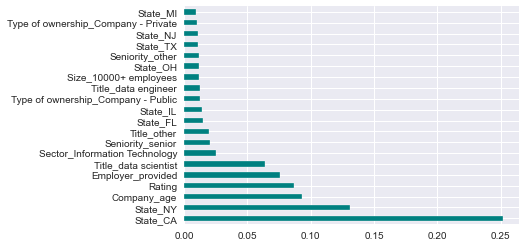

In [20]:
# Which features are more important
feat_importances = pd.Series(rfr_loaded_model.feature_importances_,
                                 index=X_test.columns)
feat_importances.nlargest(20).plot(kind='barh', color='teal')
print(feat_importances.sort_values())

# Evaluate Model Results
The top 20 features in the above plot are:
1. State_CA: this feature is equal to 1 if the position is located in California and 0 for other locations
1. State_NY: this feature is equal to 1 if the position is located in New York and 0 for other locations
1. Company_age: how old the company posting the position is
1. Rating: rating of the company on glassdoor
1. Employer_provided: this feature is equal to 1 if the salary data for the position is provided by the employer otherwise 0
1. Title_data scientist: this feature is equal to 1 if the position title contains “data scientist”
1. Sector_Information Technology: this feature is equal to 1 if the company operates in “Information Technology” sector
1. Seniority_senior: this feature is equal to 1 if the position is a senior level one
1. Title_other: this feature is equal to 1 if the position is in the data science field but the exact title is unknown
1. State_FL: this feature is equal to 1 if the position is located in Florida and 0 for other locations
1. State_IL: this feature is equal to 1 if the position is located in Illinois and 0 for other locations
1. Type of ownership_Company — Public: this feature is equal to 1 if the company is public
1. Title_data engineer: this feature is equal to 1 if the position title contains “data engineer”
1. Size_10000+ employees: this feature is equal to 1 if the company has more than 10,000 employees
1. State_OH: this feature is equal to 1 if the position is located in Ohio and 0 for other locations
1. Seniority_other: this feature is equal to 1 if the seniority level of the position is not explicitly mentioned either “senior” or “junior”
1. State_NJ: this feature is equal to 1 if the position is located in New Jersey and 0 for other locations
1. Type of ownership_Company — Private: this feature is equal to 1 if the company is private
1. State_MI: this feature is equal to 1 if the position is located in Michigan and 0 for other locations
1. Size_51 to 200 employees: this feature is equal to 1 if the company has 51–200 employees

As shown above, the most important features are State_CA, State_NY, Company_age, and so on. So I can be said that according to this model, data scientists are paid more in California, New York, and Florida, respectively.

Also, the ratings of companies are an important factor in data scientists salaries.

Additionally, “Information Technology” is the sector where data scientists are paid the highest salaries according to the above plot.

Another take from the above plot is that the larger companies pay higher salaries compared to smaller ones.